/tmp/ipython-input-21-432544517.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-21-432544517.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr


Tabela de Resultados (média ± desvio padrão):
         modelo         accuracy        precision           recall  \
0           KNN  0.8074 ± 0.0166  0.9650 ± 0.0040  0.8275 ± 0.0168   
1  RandomForest  0.9245 ± 0.0071  0.9561 ± 0.0019  0.9650 ± 0.0095   
2           ID3  0.8943 ± 0.0098  0.9568 ± 0.0040  0.9309 ± 0.0115   
3           SVM  0.7886 ± 0.0164  0.9679 ± 0.0031  0.8046 ± 0.0182   
4           MLP  0.7434 ± 0.0111  0.9808 ± 0.0069  0.7449 ± 0.0167   

                f1          roc_auc  
0  0.8909 ± 0.0103  0.6206 ± 0.0364  
1  0.9605 ± 0.0040  0.5484 ± 0.0221  
2  0.9437 ± 0.0056  0.5545 ± 0.0399  
3  0.8786 ± 0.0106  0.6409 ± 0.0242  
4  0.8466 ± 0.0085  0.7289 ± 0.0469  


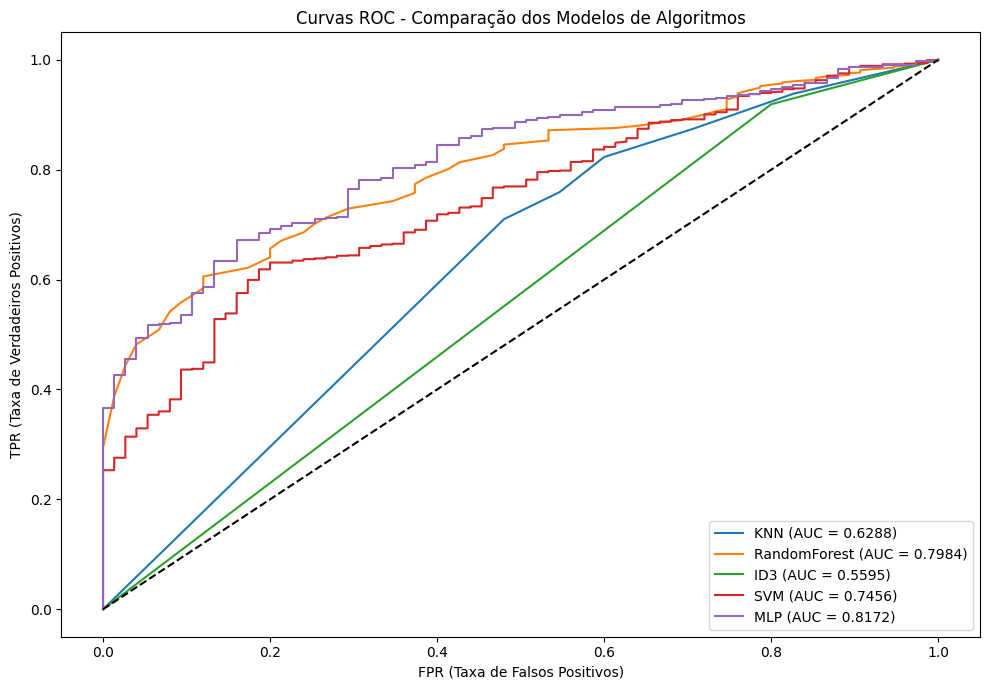

In [21]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.experimental import enable_iterative_imputer  # noqa: F401 (enables IterativeImputer)
from sklearn.impute import IterativeImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    make_scorer,
    roc_curve,
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier  # ID3
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ----ETAPAS DE PRÉ-PROCESSAMENTO--------

# ---------------------------
# 1. Baixar e carregar o conjunto de dados
# ---------------------------
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
csv_path = os.path.join(path, "healthcare-dataset-stroke-data.csv")
df = pd.read_csv(csv_path)

# ---------------------------
#2. Tratamento básico de valores ausentes
# (realizado antes da divisão, nenhuma estatística do conjunto de *teste* vazará para o treinamento porque reimputamos
# dentro de cada dobra de CV/modelo final por meio do pipeline)
# ---------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include="object").columns

for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# ---------------------------
# 3. Codificar variáveis categóricas
# ---------------------------
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# ---------------------------
# 4. Preparar o alvo e soltar os ajudantes
# ---------------------------
df["Classe_Stroke"] = df["stroke"].map({0: "Sem AVC", 1: "Com AVC"})
le_target = LabelEncoder()
df["y"] = le_target.fit_transform(df["Classe_Stroke"])

X = df.drop(columns=["stroke", "Classe_Stroke", "y"])
y = df["y"]

# ---------------------------
# 5. Divisão entre treinamento e teste (hold-out)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42,
)

# ---------------------------
# 6. Normalizar e padronizar os dados
# ---------------------------
_preprocess_steps = [
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", StandardScaler()),
]

# ---------------------------
# 7. Definições de modelos
# ---------------------------
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y))
n_hidden = (n_inputs + n_outputs) // 2

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RandomForest": RandomForestClassifier(
        random_state=42, class_weight="balanced"
    ),
    "ID3": DecisionTreeClassifier(
        criterion="entropy", random_state=42
    ),
    "SVM": SVC(
        class_weight="balanced", probability=True, random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(n_hidden,),
        activation="relu",
        learning_rate_init=0.001,
        max_iter=300,
        early_stopping=True,
        random_state=42,
    ),
}

# ---------------------------
# 8. Métricas de avaliação
# ---------------------------
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
    "roc_auc": make_scorer(roc_auc_score),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------
# 9. Validação cruzada com o SMOTE
# ---------------------------
results = []
for name, model in models.items():
    pipe = ImbPipeline(
        steps=_preprocess_steps
        + [
            ("smote", SMOTE(random_state=42)),
            ("clf", model),
        ]
    )

    scores = cross_validate(
        pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
    )

    results.append(
        {
            "modelo": name,
            "accuracy": f"{scores['test_accuracy'].mean():.4f} ± {scores['test_accuracy'].std():.4f}",
            "precision": f"{scores['test_precision'].mean():.4f} ± {scores['test_precision'].std():.4f}",
            "recall": f"{scores['test_recall'].mean():.4f} ± {scores['test_recall'].std():.4f}",
            "f1": f"{scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}",
            "roc_auc": f"{scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}",
        }
    )

results_df = pd.DataFrame(results)
print("\nTabela de Resultados (média ± desvio padrão):")
print(results_df[["modelo", "accuracy", "precision", "recall", "f1", "roc_auc"]])

# ---------------------------
# 10. Curvas ROC no teste de retenção
# ---------------------------
plt.figure(figsize=(10, 7))

for name, model in models.items():
    pipe = ImbPipeline(
        steps=_preprocess_steps
        + [
            ("smote", SMOTE(random_state=42)),
            ("clf", model),
        ]
    )

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR (Taxa de Falsos Positivos)")
plt.ylabel("TPR (Taxa de Verdadeiros Positivos)")
plt.title("Curvas ROC - Comparação dos Modelos de Algoritmos")
plt.legend(loc="lower right")
#plt.grid(True)
plt.tight_layout()
plt.show()



Resultados – Validação Cruzada:
         modelo       accuracy      precision         recall             f1  \
0           KNN  0.793 ± 0.026  0.107 ± 0.013  0.438 ± 0.058  0.171 ± 0.018   
1  RandomForest  0.864 ± 0.005  0.117 ± 0.018  0.277 ± 0.060  0.164 ± 0.028   
2           ID3  0.781 ± 0.039  0.124 ± 0.011  0.574 ± 0.107  0.203 ± 0.017   
3           SVM  0.725 ± 0.022  0.129 ± 0.009  0.803 ± 0.028  0.222 ± 0.014   
4           MLP  0.739 ± 0.019  0.134 ± 0.009  0.795 ± 0.055  0.229 ± 0.015   

         roc_auc  
0  0.624 ± 0.025  
1  0.585 ± 0.028  
2  0.683 ± 0.035  
3  0.762 ± 0.016  
4  0.765 ± 0.025  


/tmp/ipython-input-20-3992474134.py:145: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  plot_df[metric_cols] = plot_df[metric_cols].applymap(lambda x: float(x.split()[0]))


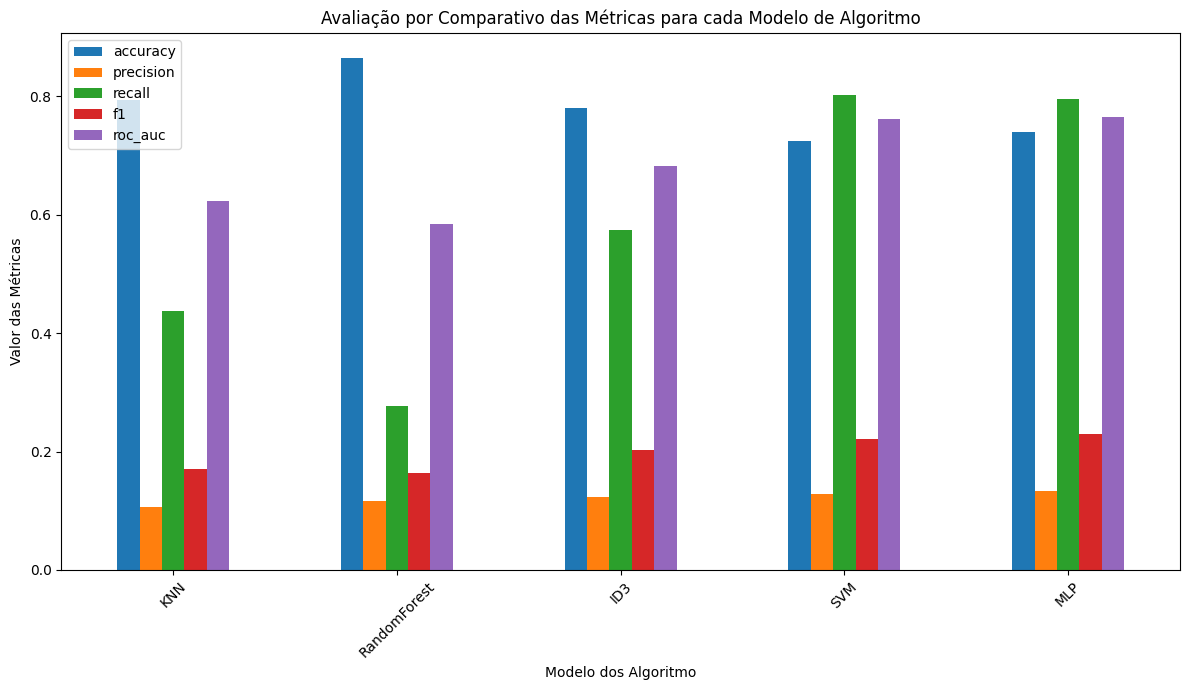

In [20]:
"""stroke_models_pipeline.py
Pipeline para modelos de predição de AVC com prevenção de vazamento de dados.
Compatível com scikit-learn ≥1.4 (usa `sparse_output=False`) e versões anteriores.
"""

import os
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    make_scorer,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ---------------------------------------------------------------------------
# 1. Carregamento dos dados
# ---------------------------------------------------------------------------
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
df = pd.read_csv(os.path.join(path, "healthcare-dataset-stroke-data.csv"))

# Remover coluna identificadora, se existir
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

# ---------------------------------------------------------------------------
# 2. Definição de X e y
# ---------------------------------------------------------------------------
X = df.drop(columns=["stroke"])
y = df["stroke"].astype(int)

# ---------------------------------------------------------------------------
# 3. Pré-processamento
# ---------------------------------------------------------------------------
num_feats = X.select_dtypes(include=[np.number]).columns.tolist()
cat_feats = X.select_dtypes(exclude=[np.number]).columns.tolist()

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# OneHotEncoder compatível com scikit-learn ≥1.4 e anteriores
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  # scikit-learn <1.2 usa 'sparse'
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_feats),
    ("cat", cat_pipe, cat_feats),
])

feature_selector = SelectKBest(score_func=f_classif, k=5) #seleciona 5 melhores caracteristicas


# ---------------------------------------------------------------------------
# 4. Modelos
# ---------------------------------------------------------------------------
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=42
    ),
    "ID3": DecisionTreeClassifier(
        criterion="entropy", max_depth=10, random_state=42
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32), activation="relu", max_iter=200,
        early_stopping=True, random_state=42
    ),
}

# ---------------------------------------------------------------------------
# 5. Métricas e validação
# ---------------------------------------------------------------------------
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
    "roc_auc": make_scorer(roc_auc_score),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, clf in models.items():
    pipe = ImbPipeline([
        ("pre", preprocessor),
        ("select", feature_selector),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf),
    ])

    scores = cross_validate(
        pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True
    )

    results.append({
        "modelo": name,
        "accuracy": f"{scores['test_accuracy'].mean():.3f} ± {scores['test_accuracy'].std():.3f}",
        "precision": f"{scores['test_precision'].mean():.3f} ± {scores['test_precision'].std():.3f}",
        "recall": f"{scores['test_recall'].mean():.3f} ± {scores['test_recall'].std():.3f}",
        "f1": f"{scores['test_f1'].mean():.3f} ± {scores['test_f1'].std():.3f}",
        "roc_auc": f"{scores['test_roc_auc'].mean():.3f} ± {scores['test_roc_auc'].std():.3f}",
    })

results_df = pd.DataFrame(results)
print("\nResultados – Validação Cruzada:")
print(results_df)

# ---------------------------------------------------------------------------
# 6. Visualização
# ---------------------------------------------------------------------------
metric_cols = ["accuracy", "precision", "recall", "f1", "roc_auc"]
plot_df = results_df.copy()
plot_df[metric_cols] = plot_df[metric_cols].applymap(lambda x: float(x.split()[0]))
plot_df.set_index("modelo")[metric_cols].plot(kind="bar", figsize=(12, 7))
plt.title("Avaliação por Comparativo das Métricas para cada Modelo de Algoritmo")
plt.ylabel("Valor das Métricas")
plt.xlabel("Modelo dos Algoritmo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()